In [2]:
import json
from pathlib import Path
import pandas as pd

**Python code-comment dataset from CodeSearchNet challenge**

In [3]:
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
!unzip python.zip
!gzip -d python/final/jsonl/test/python_test_0.jsonl.gz

--2020-12-08 12:11:48--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.108.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.108.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 940909997 (897M) [application/zip]
Saving to: ‘python.zip’

python.zip          100%[===================>] 897.32M  75.2MB/s    in 12s     

2020-12-08 12:11:59 (77.7 MB/s) - ‘python.zip’ saved [940909997/940909997]

Archive:  python.zip
   creating: python/
   creating: python/final/
   creating: python/final/jsonl/
   creating: python/final/jsonl/train/
  inflating: python/final/jsonl/train/python_train_9.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_12.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_10.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_0.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_6.jsonl.gz  
  inflating: python/final

In [4]:
python_files = sorted(Path('python/').glob('**/*.gz'))
python_columns_list = ['repo', 'path', 'url', 'code', 
                'code_tokens', 'docstring', 'docstring_tokens', 
                'language', 'partition']

# Convert downloaded json files into a dataframe
python_data = pd.concat([pd.read_json(file,
                        orient='records',
                        compression='gzip',
                        lines=True)[python_columns_list] for file in python_files],
                        sort=False)

python_data.head(5)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,ageitgey/face_recognition,examples/face_recognition_knn.py,https://github.com/ageitgey/face_recognition/b...,"def train(train_dir, model_save_path=None, n_n...","[def, train, (, train_dir, ,, model_save_path,...",Trains a k-nearest neighbors classifier for fa...,"[Trains, a, k, -, nearest, neighbors, classifi...",python,train
1,ageitgey/face_recognition,examples/face_recognition_knn.py,https://github.com/ageitgey/face_recognition/b...,"def predict(X_img_path, knn_clf=None, model_pa...","[def, predict, (, X_img_path, ,, knn_clf, =, N...",Recognizes faces in given image using a traine...,"[Recognizes, faces, in, given, image, using, a...",python,train
2,ageitgey/face_recognition,examples/face_recognition_knn.py,https://github.com/ageitgey/face_recognition/b...,"def show_prediction_labels_on_image(img_path, ...","[def, show_prediction_labels_on_image, (, img_...",Shows the face recognition results visually.\n...,"[Shows, the, face, recognition, results, visua...",python,train
3,ageitgey/face_recognition,face_recognition/api.py,https://github.com/ageitgey/face_recognition/b...,"def _rect_to_css(rect):\n """"""\n Convert ...","[def, _rect_to_css, (, rect, ), :, return, rec...",Convert a dlib 'rect' object to a plain tuple ...,"[Convert, a, dlib, rect, object, to, a, plain,...",python,train
4,ageitgey/face_recognition,face_recognition/api.py,https://github.com/ageitgey/face_recognition/b...,"def _trim_css_to_bounds(css, image_shape):\n ...","[def, _trim_css_to_bounds, (, css, ,, image_sh...","Make sure a tuple in (top, right, bottom, left...","[Make, sure, a, tuple, in, (, top, right, bott...",python,train


In [36]:
!pip install showast
!pip install graphviz

import ast
import graphviz
import itertools
from functools import partial, reduce
from IPython.display import SVG

#Reference: https://github.com/hchasestevens/show_ast

_basestring = str
def recurse_through_ast(node, handle_ast, handle_terminal, handle_fields, handle_no_fields, omit_docstrings):
    possible_docstring = isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.Module))
    
    node_fields = zip(
        node._fields,
        (getattr(node, attr) for attr in node._fields)
    )
    field_results = []
    for field_name, field_value in node_fields:
        if isinstance(field_value, ast.AST):
            field_results.append(handle_ast(field_value))
        
        elif isinstance(field_value, list):
            if possible_docstring and omit_docstrings and field_name == 'body':
                field_value = _strip_docstring(field_value)
            field_results.extend(
                handle_ast(item)
                if isinstance(item, ast.AST) else
                handle_terminal(item)
                for item in field_value
            )
        
        elif isinstance(field_value, _basestring):
            field_results.append(handle_terminal('"{}"'.format(field_value)))
            
        elif field_value is not None:
            field_results.append(handle_terminal(field_value))

    if not field_results:
        return handle_no_fields(node)

    return handle_fields(node, field_results)

my_settings = dict(
    # Styling options:
    scale=2,
    font='courier',
    shape='none',
    terminal_color='#800040',
    nonterminal_color='#004080',
    # AST display options:
    omit_module=True,
    omit_docstrings=True,
)

def _strip_docstring(body):
    first = body[0]
    if isinstance(first, ast.Expr) and isinstance(first.value, ast.Str):
        return body[1:]
    return body

def _bold(label):
    return '<<B>{}</B>>'.format(label)


def _attach_to_parent(parent, graph, names, label, name=None, **style):
    node_name = next(names) if name is None else name
    node = graph.node(node_name, label=label, **style)
    if parent is not None:
        graph.edge(parent, node_name, sametail='t{}'.format(parent))


def handle_ast(node, parent_node, graph, names, omit_docstrings, terminal_color, nonterminal_color):
    attach_to_parent = partial(
        _attach_to_parent,
        graph=graph,
        names=names,
    )
    node_name = next(names)
    attach_to_parent(
        parent=parent_node,
        label=_bold(node.__class__.__name__),
        name=node_name,
        fontcolor=nonterminal_color,
    )
    recurse_through_ast(
        node, 
        partial(
            handle_ast, 
            parent_node=node_name,
            graph=graph,
            names=names,
            omit_docstrings=omit_docstrings, 
            terminal_color=terminal_color, 
            nonterminal_color=nonterminal_color,
        ), 
        partial(
            handle_terminal, 
            attach_to_parent=partial(
                attach_to_parent, 
                parent=node_name, 
                fontcolor=terminal_color,
            ),
        ), 
        handle_fields, 
        partial(
            handle_no_fields,
            parent_node=node_name,
            graph=graph,
            terminal_color=terminal_color,
            nonterminal_color=nonterminal_color,
        ),
        omit_docstrings,
    )


def handle_terminal(terminal, attach_to_parent):
    attach_to_parent(label=str(terminal))


def handle_fields(*__):
    pass


def handle_no_fields(__, parent_node, graph, terminal_color, nonterminal_color):
    parent_node_beginning = '{} '.format(parent_node)
    parent_node_num = int(parent_node)
    for i, node in enumerate(graph.body[parent_node_num:]):
        if node.strip().startswith(parent_node_beginning):
            break
    else:
        raise KeyError("Could not find parent in graph.")
    replacements = {
        nonterminal_color: terminal_color,
        '<<B>': '',
        '</B>>': '',
    }
    graph.body[i + parent_node_num] = reduce(
        lambda s, replacement: s.replace(*replacement),
        replacements.items(),
        node,
    )
    
def render(node, settings):
    """
    Given an AST node and settings, return a displayable object.
    """
    graph = graphviz.Graph(format='svg')
    names = (str(x) for x in itertools.count())

    handle_ast(
        node,
        parent_node=None,
        graph=graph,
        names=names,
        omit_docstrings=settings['omit_docstrings'],
        terminal_color=settings['terminal_color'],
        nonterminal_color=settings['nonterminal_color'],
    )

    graph.node_attr.update(dict(
        fontname=settings['font'],
        shape=settings['shape'],
    ))

    return SVG(graph.pipe(format='svg'))

def viz_code(code):
    return render(ast.parse(code), my_settings)

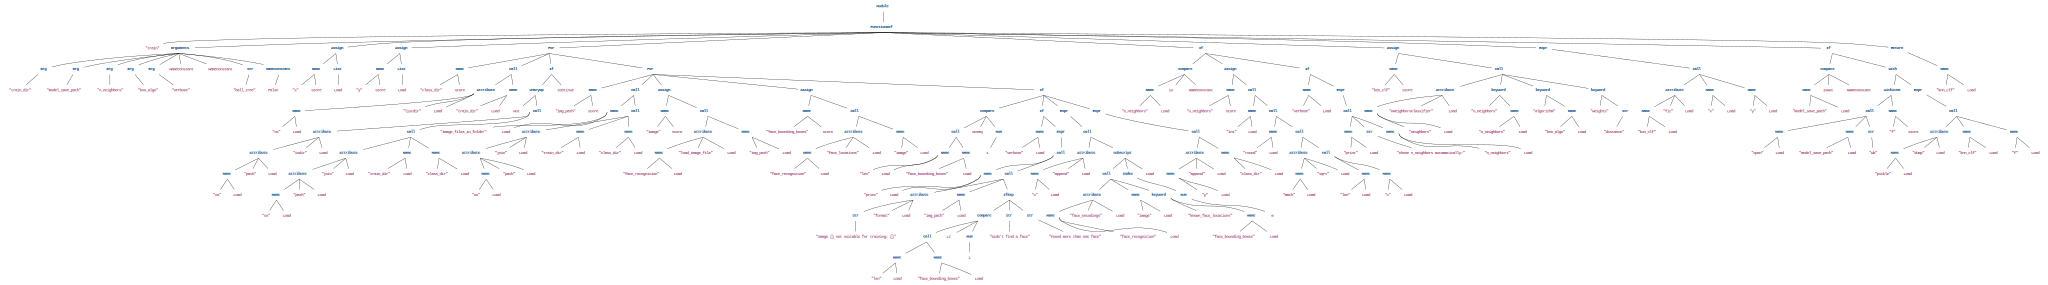

In [38]:
_strip_docstring(ast.dump(ast.parse(python_data['code'].tolist()[0])))
viz_code(python_data['code'].tolist()[0])

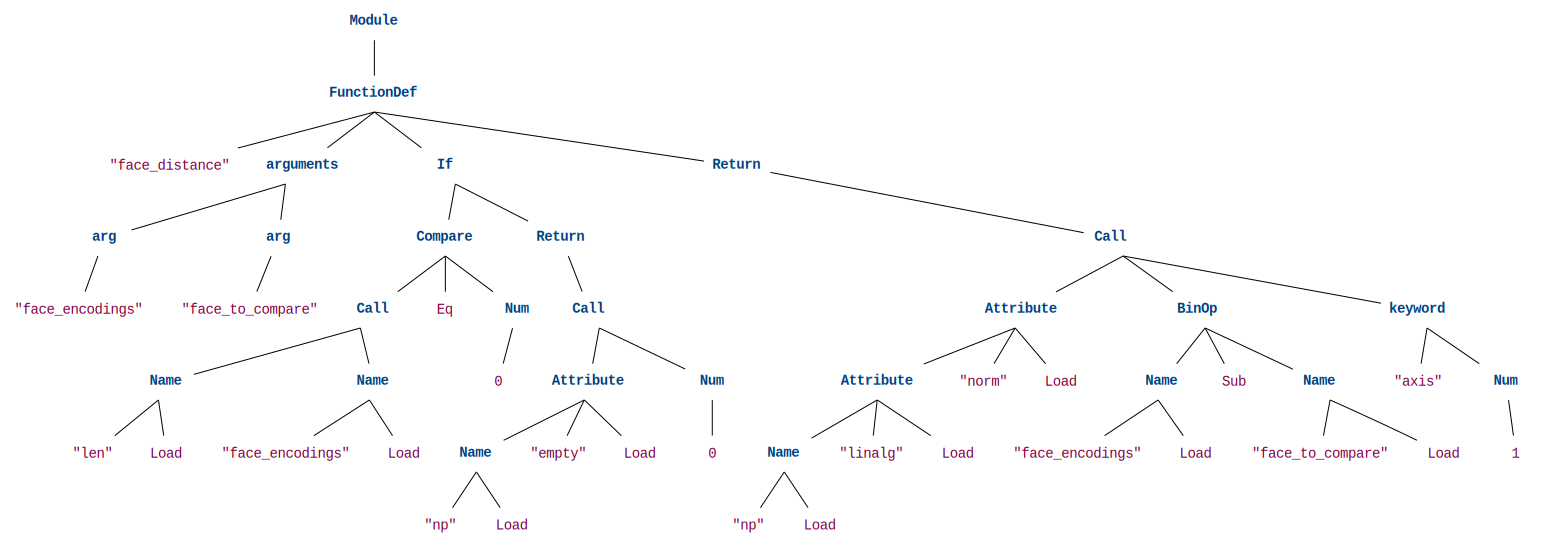

In [39]:
_strip_docstring(ast.dump(ast.parse(python_data['code'].tolist()[5])))
viz_code(python_data['code'].tolist()[5])

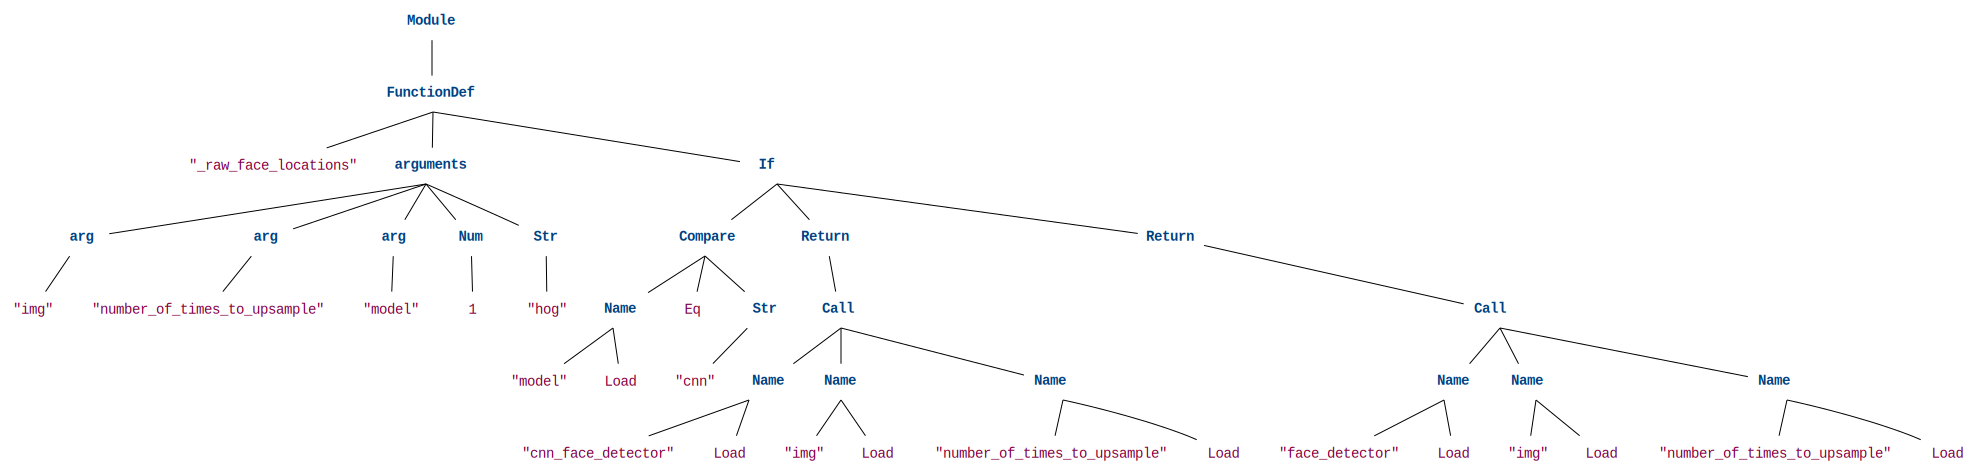

In [40]:
_strip_docstring(ast.dump(ast.parse(python_data['code'].tolist()[7])))
viz_code(python_data['code'].tolist()[7])

**Java code-comment dataset from CodeSearchNet challenge**

In [ ]:
!rm java.*
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
!unzip java.zip
!gzip -d java/final/jsonl/test/java_test_0.jsonl.gz

--2020-11-29 21:12:36--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.147
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060569153 (1011M) [application/zip]
Saving to: ‘java.zip’

java.zip            100%[===================>]   1011M  16.6MB/s    in 63s     

2020-11-29 21:13:41 (15.9 MB/s) - ‘java.zip’ saved [1060569153/1060569153]

Archive:  java.zip
replace java/final/jsonl/train/java_train_12.jsonl.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: java/final/jsonl/train/java_train_12.jsonl.gz  
replace java/final/jsonl/train/java_train_9.jsonl.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: java/final/jsonl/train/java_train_9.jsonl.gz  
replace java/final/jsonl/train/java_train_3.jsonl.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: java/final/jsonl/train/java_train_3.jsonl.gz  
repla

In [ ]:
java_files = sorted(Path('java/').glob('**/*.gz'))
java_columns_list = ['repo', 'path', 'url', 'code', 
                'code_tokens', 'docstring', 'docstring_tokens', 
                'language', 'partition']

# Convert downloaded json files into a dataframe
java_data = pd.concat([pd.read_json(file,
                        orient='records',
                        compression='gzip',
                        lines=True)[java_columns_list] for file in java_files],
                        sort=False)

java_data.head(5)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,spring-projects/spring-boot,spring-boot-project/spring-boot/src/main/java/...,https://github.com/spring-projects/spring-boot...,protected final void bindIndexed(Configuration...,"[protected, final, void, bindIndexed, (, Confi...",Bind indexed elements to the supplied collecti...,"[Bind, indexed, elements, to, the, supplied, c...",java,train
1,spring-projects/spring-boot,spring-boot-project/spring-boot/src/main/java/...,https://github.com/spring-projects/spring-boot...,public void setServletRegistrationBeans(\n\t\t...,"[public, void, setServletRegistrationBeans, (,...",Set {@link ServletRegistrationBean}s that the ...,"[Set, {]",java,train
2,spring-projects/spring-boot,spring-boot-project/spring-boot/src/main/java/...,https://github.com/spring-projects/spring-boot...,public void addServletRegistrationBeans(\n\t\t...,"[public, void, addServletRegistrationBeans, (,...",Add {@link ServletRegistrationBean}s for the f...,"[Add, {]",java,train
3,spring-projects/spring-boot,spring-boot-project/spring-boot/src/main/java/...,https://github.com/spring-projects/spring-boot...,public void setServletNames(Collection<String>...,"[public, void, setServletNames, (, Collection,...",Set servlet names that the filter will be regi...,"[Set, servlet, names, that, the, filter, will,...",java,train
4,spring-projects/spring-boot,spring-boot-project/spring-boot/src/main/java/...,https://github.com/spring-projects/spring-boot...,public void addServletNames(String... servletN...,"[public, void, addServletNames, (, String, ......",Add servlet names for the filter.\n@param serv...,"[Add, servlet, names, for, the, filter, .]",java,train
